In [10]:
import seaborn as sns
import scipy.signal as ssig
import lalsimulation as lalsim
import matplotlib.pyplot as pl
import qnm_filter
import numpy as np

sns.set(context='notebook', palette='colorblind')

In [11]:
psd_func_dict = {
    'H1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'L1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsim.SimNoisePSDAdvVirgo,
}
ifos = list(psd_func_dict.keys())


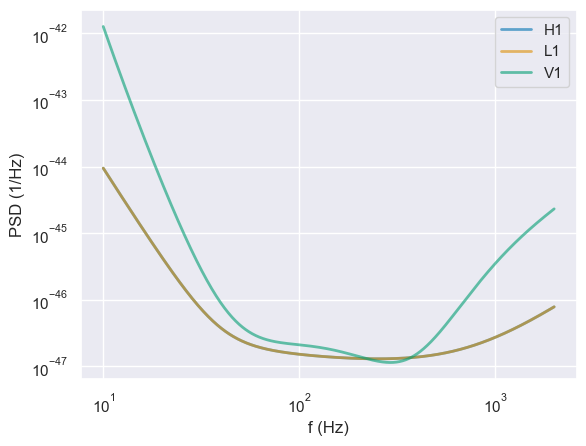

In [14]:
fs = np.linspace(10, 2E3, 4096)
for ifo, psd in psd_func_dict.items():
    pl.loglog(fs, np.vectorize(psd)(fs), label=ifo, alpha=0.6, lw=2)
pl.xlabel('f (Hz)')
pl.ylabel('PSD (1/Hz)')
pl.legend();


In [15]:
# define center of time array
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 8192
duration = 16

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

epoch = tgps_geo - 0.5*tlen*delta_t

time_dict = {i: np.arange(tlen)*delta_t + epoch for i in ifos}


In [18]:
freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]

# we will want to pad low frequencies; the function below applies a
# prescription to do so smoothly, but this is not really needed: you
# could just set all values below `fmin` to a constant.
fmin = 10
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = psd


In [19]:
rng = np.random.default_rng(12345)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag


In [20]:
# IFFT into the time domain
noise_td_dict = {}
for ifo, noise_fd in noise_fd_dict.items():
    noise_td_dict[ifo] = np.fft.irfft(noise_fd) / delta_t


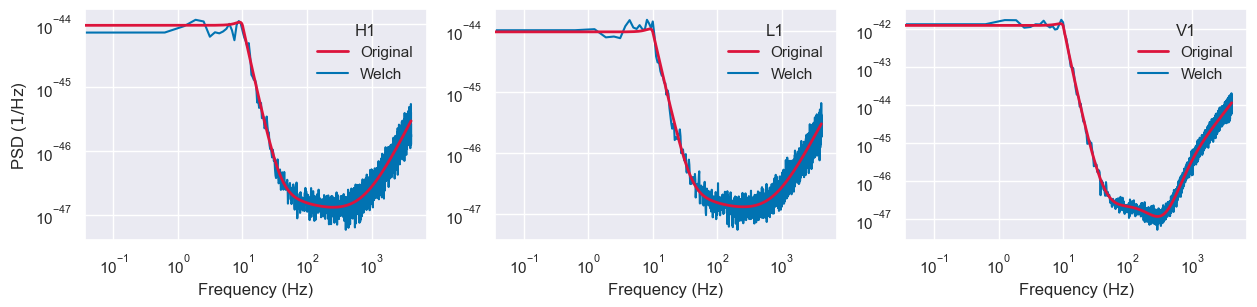

In [21]:
fig, axs = pl.subplots(1, len(ifos), figsize=(5*len(ifos), 3))
for ax, (ifo, noise) in zip(axs, noise_td_dict.items()):
    # compute Welch PSD
    psd_freq, psd_data = ssig.welch(noise, fs=1./delta_t, nperseg=0.1*duration/delta_t)
    
    ax.loglog(freqs, psd_dict[ifo], label='Original', c='crimson', lw=2, zorder=100)
    ax.loglog(psd_freq, psd_data, label='Welch')
    ax.legend(loc='upper right', frameon=False, title=ifo);
    ax.set_xlabel("Frequency (Hz)");
    # ax.set_ylim(1E-47, 1E-46)
axs[0].set_ylabel(r"PSD ($1/\mathrm{Hz}$)");


In [26]:
psd_dict['H1']

array([9.46816698e-45, 9.46824985e-45, 9.46833744e-45, ...,
       2.97553418e-46, 2.97562202e-46, 2.97570985e-46])

In [22]:
acf_dict = {}
for ifo, psd in psd_dict.items():
    acf_dict[ifo] = 0.5*np.fft.irfft(psd) / delta_t


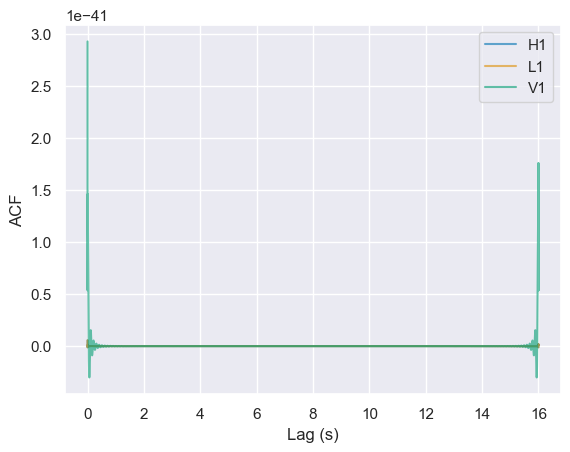

In [24]:
for ifo, acf in acf_dict.items():
    pl.plot(delta_t*np.arange(len(acf)), acf, label=ifo, alpha=0.6)
pl.xlabel('Lag (s)')
pl.ylabel('ACF')
pl.legend();


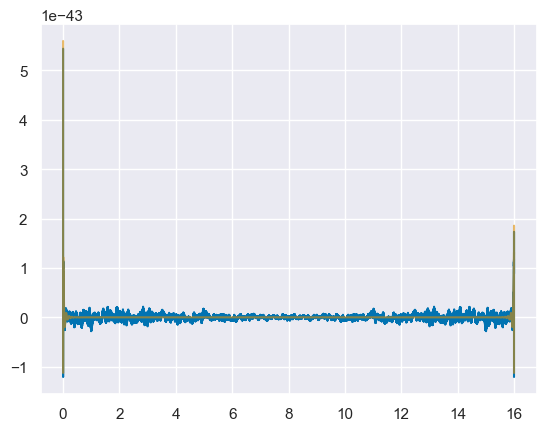

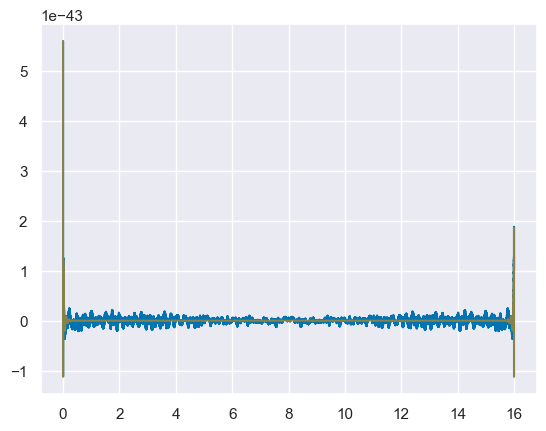

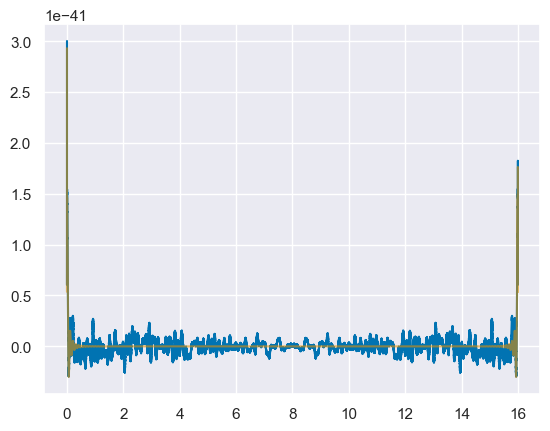

In [25]:
for ifo in ['H1', 'L1', 'V1']:
    fit = qnm_filter.Network(segment_length=0.2, srate=fsamp, t_init=tgps_geo) # 0.2 is irrelevant
    fit.original_data[ifo] = qnm_filter.RealData(noise_td_dict[ifo], index=time_dict[ifo], ifo=ifo)
    fit.detector_alignment()
    fit.compute_acfs("original_data", sampling_rate=1/duration)
    fit.cholesky_decomposition()
    
    pl.figure()
    pl.plot(fit.acfs[ifo].index, fit.acfs[ifo].values)
    pl.plot(delta_t*np.arange(len(acf)), acf_dict[ifo], label=ifo, alpha=0.6)
    
